In [1]:
import matplotlib
import ipywidgets as widgets
from typing import Optional
import math
from matplotlib import animation
from IPython.display import HTML
import datetime
import xarray
import xarray as xr
import pygrib
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def select(
    data: xarray.Dataset,
    variable: str,
    level: Optional[int] = None,
    max_steps: Optional[int] = None
    ) -> xarray.Dataset:
  data = data[variable]
  if "batch" in data.dims:
    data = data.isel(batch=0)
  if max_steps is not None and "time" in data.sizes and max_steps < data.sizes["time"]:
    data = data.isel(time=range(0, max_steps))
  if level is not None and "level" in data.coords:
    data = data.sel(level=level)
  return data
def scale(
    data: xarray.Dataset,
    center: Optional[float] = None,
    robust: bool = False,
    ) -> tuple[xarray.Dataset, matplotlib.colors.Normalize, str]:
  vmin = np.nanpercentile(data, (2 if robust else 0))
  vmax = np.nanpercentile(data, (98 if robust else 100))
  if center is not None:
    diff = max(vmax - center, center - vmin)
    vmin = center - diff
    vmax = center + diff
  return (data, matplotlib.colors.Normalize(vmin, vmax),
          ("RdBu_r" if center is not None else "viridis"))

In [3]:
def plot_data(
    data: dict[str, xarray.Dataset],
    fig_title: str,
    plot_size: float = 5,
    robust: bool = False,
    cols: int = 4
    ) -> tuple[xarray.Dataset, matplotlib.colors.Normalize, str]:

  first_data = next(iter(data.values()))[0]
  max_steps = first_data.sizes.get("time", 1)
  assert all(max_steps == d.sizes.get("time", 1) for d, _, _ in data.values())

  cols = min(cols, len(data))
  rows = math.ceil(len(data) / cols)
  figure = plt.figure(figsize=(plot_size * 2 * cols,
                               plot_size * rows))
  figure.suptitle(fig_title, fontsize=16)
  figure.subplots_adjust(wspace=0, hspace=0)
  figure.tight_layout()

  images = []
  for i, (title, (plot_data, norm, cmap)) in enumerate(data.items()):
    ax = figure.add_subplot(rows, cols, i+1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(title)
    im = ax.imshow(
        plot_data.isel(time=0, missing_dims="ignore"), norm=norm,
        origin="lower", cmap=cmap)
    plt.colorbar(
        mappable=im,
        ax=ax,
        orientation="vertical",
        pad=0.02,
        aspect=16,
        shrink=0.75,
        cmap=cmap,
        extend=("both" if robust else "neither"))
    images.append(im)

  def update(frame):
    if "time" in first_data.dims:
      td = datetime.timedelta(microseconds=first_data["time"][frame].item() / 1000)
      figure.suptitle(f"{fig_title}, {td}", fontsize=16)
    else:
      figure.suptitle(fig_title, fontsize=16)
    for im, (plot_data, norm, cmap) in zip(images, data.values()):
      im.set_data(plot_data.isel(time=frame, missing_dims="ignore"))

  ani = animation.FuncAnimation(
      fig=figure, func=update, frames=max_steps, interval=250)
  plt.close(figure.number)
  return HTML(ani.to_jshtml())

In [4]:
era5 = xr.open_dataset('ERA5/ERA5.t2m.2021032300.nc')

plot_example_variable = widgets.Dropdown(
    options=era5.data_vars.keys(),
    value="t2m",
    description="Variable")
plot_example_robust = widgets.Checkbox(value=True, description="Robust")
plot_example_max_steps = widgets.IntSlider(
    min=1, max=era5.dims["time"], value=era5.dims["time"],
    description="Max steps")

widgets.VBox([
    plot_example_variable,
    plot_example_robust,
    plot_example_max_steps,
    widgets.Label(value="Run the next cell to plot the data. Rerunning this cell clears your selection.")
])

In [ ]:
# @title Plot example data

plot_size = 7

data = {
    " ": scale(select(era5, plot_example_variable.value, plot_example_max_steps.value),
              robust=plot_example_robust.value),
}
fig_title = plot_example_variable.value
if "level" in era5[plot_example_variable.value].coords:
  fig_title += f" at {plot_example_level.value} hPa"

plot_data(data, fig_title, plot_size, plot_example_robust.value)

In [5]:
gfs = xr.open_dataset('GFS/GFS.t2m.2021032300.nc')

plot_example_variable = widgets.Dropdown(
    options=gfs.data_vars.keys(),
    value="t2m",
    description="Variable")
plot_example_robust = widgets.Checkbox(value=True, description="Robust")
plot_example_max_steps = widgets.IntSlider(
    min=1, max=gfs.dims["time"], value=gfs.dims["time"],
    description="Max steps")

widgets.VBox([
    plot_example_variable,
    plot_example_robust,
    plot_example_max_steps,
    widgets.Label(value="Run the next cell to plot the data. Rerunning this cell clears your selection.")
])

In [ ]:
# @title Plot example data

plot_size = 7

data = {
    " ": scale(select(gfs, plot_example_variable.value, plot_example_max_steps.value),
              robust=plot_example_robust.value),
}
fig_title = plot_example_variable.value
if "level" in gfs[plot_example_variable.value].coords:
  fig_title += f" at {plot_example_level.value} hPa"

plot_data(data, fig_title, plot_size, plot_example_robust.value)

In [6]:
era5

<xarray.Dataset>
Dimensions:    (longitude: 1440, latitude: 721, time: 50)
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * time       (time) datetime64[ns] 2021-03-23 ... 2021-03-25T01:00:00
Data variables:
    t2m        (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2023-10-20 14:54:20 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [7]:
gfs

<xarray.Dataset>
Dimensions:    (time: 50, latitude: 721, longitude: 1440)
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * time       (time) datetime64[ns] 2021-03-23 ... 2021-03-25T01:00:00
Data variables:
    t2m        (time, latitude, longitude) float32 ...

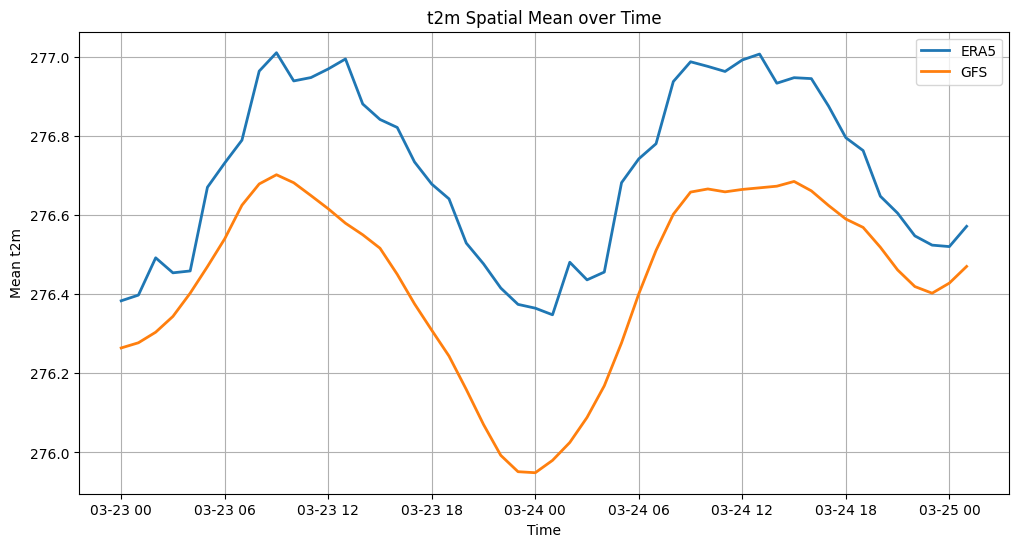

In [8]:
myDatetime = "2021032300"
# Load ERA5 and GFS datasets (replace with actual file paths)
era5_dataset = xr.open_dataset(f'ERA5/ERA5.t2m.{myDatetime}.nc')
gfs_dataset = xr.open_dataset(f'GFS/GFS.t2m.{myDatetime}.nc')

variable_name = 't2m'

# Create DataArrays for the selected variable
era5_data = era5_dataset[variable_name]
gfs_data = gfs_dataset[variable_name]

# Calculate spatial means along lon and lat dimensions
era5_spatial_mean = era5_data.mean(dim=["longitude", "latitude"])
gfs_spatial_mean = gfs_data.mean(dim=["longitude", "latitude"])

# Plot the spatial means for the first 50 time steps
num_time_steps = 50
time = era5_spatial_mean['time'][:num_time_steps].values

plt.figure(figsize=(12, 6))
plt.plot(time, era5_spatial_mean.values[:num_time_steps], label='ERA5', linewidth=2)
plt.plot(time, gfs_spatial_mean.values[:num_time_steps], label='GFS', linewidth=2)

plt.xlabel('Time')
plt.ylabel(f'Mean {variable_name}')
plt.title(f'{variable_name} Spatial Mean over Time')
plt.legend()
plt.grid(True)
plt.show()

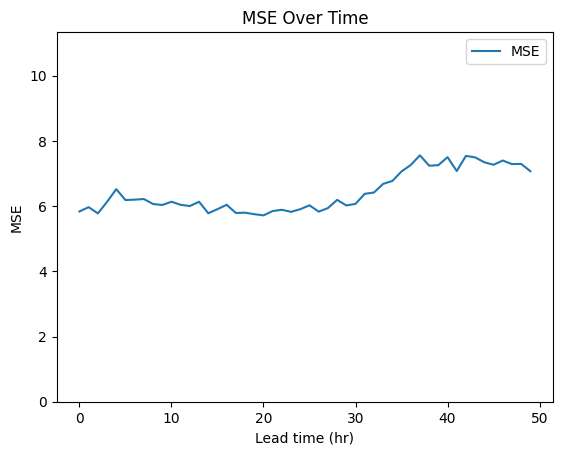

In [9]:
# Calculate the Mean Squared Error (MSE) over time
mse = ((era5_dataset - gfs_dataset) ** 2).mean(dim=['latitude', 'longitude'])

mse = mse['t2m']
mse_data = mse.values

# Create a time array corresponding to the number of time steps
time = range(len(mse_data))  # Access the length of 'mse_data'

# Now you can plot the MSE
plt.plot(time, mse_data, label='MSE')
plt.xlabel('Lead time (hr)')
plt.ylabel('MSE')
plt.title('MSE Over Time')
plt.ylim(0, 1.5*max(mse_data))  # Set the lower limit to 0 and the upper limit to the maximum value in mse_data
plt.legend()
plt.show()